In [3]:

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import seaborn as sns
sns.set_style("darkgrid")
nltk.download('stopwords')
nltk.download('punkt')
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ezdoronok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ezdoronok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
df = pd.read_csv('nature_10.csv', sep = '\t', header = None) # считал датасет
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Chromatin remodeling regulated by steroid and ...,Cell Research,1748-7838,10.1038/cr.1997.14,7.0,2.0,1997.0,127-142,"Wolffe, Alan P","Wolffe, Alan P#:#Laboratory of Molecular Embro...",Coactivators and corepressors regulate transcr...,citation_journal_title=Ann Rev Genet; citation...,NaN
1,Biochemical detection of alien DNA incorporate...,Heredity,1365-2540,10.1038/hdy.1978.49,40.0,3.0,1978.0,439-455,"Flavell, Richard;O'Dell, Michael;Rimpau, Jürge...","Flavell, Richard#:#Department of Cytogenetics,...",Wheat lines carrying homologous pairs of compl...,"Barber, H N, Driscoll, C J, and Vickery, R S. ...",NaN
2,Early Archaean Age for the Isua Iron Formation...,Nature,1476-4687,10.1038/245138a0,245.0,5421.0,1973.0,138-139,"MOORBATH, S.;O'NIONS, R. K.;PANKHURST, R. J.","MOORBATH, S.#:#Department of Geology, Universi...","SOME 150 km north-east of Godthaab, on the edg...",citation_journal_title=Nature; citation_author...,NaN
3,Technical Education Abstracts,Nature,1476-4687,10.1038/193222a0,193.0,4812.0,1962.0,222-222,NaN,NaN,NaN,NaN,NaN
4,The Utility of Specific Characters,Nature,1476-4687,10.1038/054365b0,54.0,1399.0,1896.0,365-366,"LANKESTER, E. RAY","LANKESTER, E. RAY#:#Dinard, Bretagne",I REGRET very much that I did not correctly re...,NaN,NaN


In [8]:
df = df.rename({0:'title', 1:'journal', 2:'eissn',3:'doi',4:'volume',
                5:'issue',6:'year',7:'pages',8:'author',9:'affiliation',
               10:'text', 11:'citation', 12:'contacts'}, axis = 1) #переименовал колонки

In [9]:
df.shape

(10000, 13)

In [10]:
df[df['text'].isna() == False].shape 

(7805, 13)

In [11]:
df = df[df['text'].isna() == False] #избавлюсь от тех семплов, где нету краткого содержания статьи

In [12]:
df['title'].fillna(value="", inplace=True) # заменю пустые значения названий

In [13]:
# перемешиваю сэмплы
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

,title,journal,eissn,doi,volume,issue,year,pages,author,affiliation,text,citation,contacts
0,Increased levels of immune transcript in patie...,Bone Marrow Transplantation,1476-5365,10.1038/sj.bmt.1703807,31.0,3.0,2003.0,183-190,"Jaksch, M;Uzunel, M;Martinez Cangana, G;Rember...","Jaksch, M#:#Division of Clinical Immunology, K...",After allogeneic stem cell transplantation (SC...,citation_journal_title=N Engl J Med; citation_...,NaN
1,Natural Selection,Nature,1476-4687,10.1038/124410a0,124.0,3124.0,1929.0,410-410,"GARSTANG, WALTER","GARSTANG, WALTER#:#Leeds",THE confusions and obscurities in Prof. MacBri...,NaN,NaN
2,Development of a low-cost strabismus surgery s...,Eye,1476-5454,10.1038/s41433-020-0966-1,35.0,3.0,2021.0,805-810,"Malik, Mohsan;Shah, Neil;Kit, Vivienne;Jain, S...","Malik, Mohsan#:#Ophthalmic Specialist Trainee,...",Strabismus surgery training has historically f...,Royal College of Ophthalmology Ophthalmic Spec...,Mohsan Malik#:#Mohsan.m.malik@gmail.com
3,The reflective practitioner — another way of l...,British Dental Journal,1476-5373,10.1038/sj.bdj.4811969,198.0,2.0,2005.0,67-68,"Toy, A","Toy, A#:#Gorse Covert Dental Practice,#|#Unive...",Research outcomes are of no value if the metho...,citation_title=Qualitative-quantitative resear...,A Toy#:#andy.toy@talk21.com
4,High-sensitivity intravascular photoacoustic i...,Scientific Reports,2045-2322,10.1038/srep25236,6.0,1.0,2016.0,1-8,"Cao, Yingchun;Hui, Jie;Kole, Ayeeshik;Wang, Pu...","Cao, Yingchun#:#Weldon School of Biomedical En...",A highly sensitive catheter probe is critical ...,citation_journal_title=Circulation; citation_t...,NaN


In [14]:
def initial_clean(text):
    """
    Функция, которая чистит текст от ссылок, адресов почт и пунктуации.
    Также приводит текст к нижнему регистру
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower()
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Избавляюсь от стоп-слов
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Привожу слова к основам слов
    """
    text = [stemmer.stem(word) for word in text]
    text = [word for word in text if len(word) > 1] # Избавляюсь от 1 символьных слов 
    return text

def apply_all(text):
    """
    Применяю все функции обработки текста
    """
    return stem_words(remove_stop_words(initial_clean(text)))

<>:6: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \S
C:\Users\ezdoronok\AppData\Local\Temp\ipykernel_9868\3830195738.py:6: DeprecationWarning: invalid escape sequence \S
  text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)


In [15]:
%%time
df['tokenized'] = df['text'].apply(apply_all) + df['title'].apply(apply_all) # Очищаю текст и название 

Wall time: 20.8 s


In [16]:
# Получаю список всех слов встречающихся в текстах
all_words = [word for item in list(df['tokenized']) for word in item]
# Используя библиотеку nltk, получаю словарь с частотой слов
fdist = FreqDist(all_words)
len(fdist) # Количество уникальных слов

48336

In [17]:
top_k_words = fdist.most_common()

In [18]:
# оставляю лишь те слова, которые встречаются хотя бы 14 раз
top_k_words = [x for x in top_k_words if x[1] >= 14]

In [19]:
len(top_k_words)

6166

In [20]:
# Функция, которая оставляет только те слова, которые встречаются 14 и больше раз
top_k_words,_ = zip(*top_k_words)
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [21]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [22]:
df['tokenized'].apply(lambda x: len(x)).values

array([130,  15, 139, ...,  30, 121, 101], dtype=int64)

In [23]:
# Теперь, посчитаю количество токенов после преобразования
doc_lengths = df['tokenized'].apply(len).values


print("Всего текстов:",len(doc_lengths),
      "\nСредняя длина текста:", np.average(doc_lengths),
      "\nМинимальная длина текста:", min(doc_lengths),
      "\nМаксимальная длина текста:", max(doc_lengths))

Всего текстов: 7805 
Средняя длина текста: 97.35874439461884 
Минимальная длина текста: 0 
Максимальная длина текста: 963


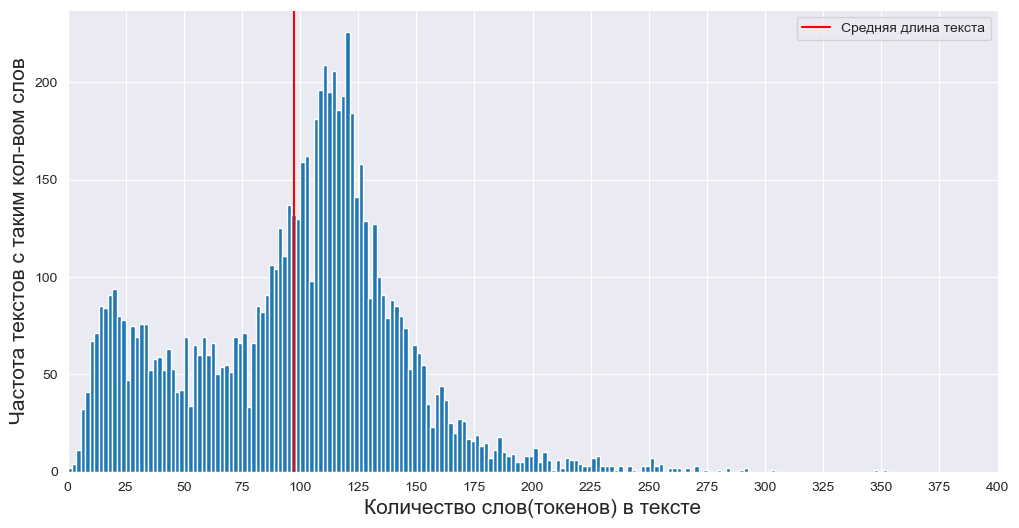

In [25]:
# Строю гистограмму, чтобы посмотреть распределение длины текстов
fig, ax = plt.subplots(figsize=(12,6))
n, bins, patches = ax.hist(doc_lengths, 500)
ax.set_xlabel('Количество слов(токенов) в тексте', fontsize=15)
ax.set_ylabel('Частота текстов с таким кол-вом слов', fontsize=15)
ax.grid()
ax.set_xticks(np.linspace(0,400, 17))
plt.xlim(0,400)
plt.axvline(np.average(doc_lengths), color = 'red', label='Средняя длина текста')
ax.legend()
ax.grid()
plt.show()

In [24]:
# Оставляю только те статьи, в которых кол-во токенов больше 30, иначе слишком короткие тексты
df = df[df['tokenized'].map(len) >= 30]
df.reset_index(drop=True,inplace=True)
print("После чистки и исключения коротких статей в датафрейме осталось:", len(df), "статей")

После чистки и исключения коротких статей в датафрейме осталось: 6907 статей


In [25]:
from sklearn.model_selection import train_test_split

In [26]:
train_df, test_df = train_test_split(df, train_size = 0.98)

In [27]:
print(len(df),len(train_df),len(test_df))

6907 6768 139


In [29]:

num_topics = 30 
dictionary = corpora.Dictionary(train_df['tokenized']) 
corpus = [dictionary.doc2bow(doc) for doc in train_df['tokenized']]
'''
Я выбрал количество тем, на которые разобьет модель мои тексты. Далее забрасываю список текстов в класс Dictionary,
создавая словарь, в котором каждому слову присваивается id. Теперь получаю список corpus, в котором хранятся списки картежей.
В картеже хранятся пара чисел вида (word_id, frec_word).
'''
pass

In [30]:
corpus[0]

[(0, 1),
 (1, 2),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 2),
 (7, 1),
 (8, 1),
 (9, 4),
 (10, 2),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 4),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 4),
 (22, 2),
 (23, 2),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 2),
 (30, 2),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 3),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 2),
 (52, 1),
 (53, 1),
 (54, 2),
 (55, 1),
 (56, 1),
 (57, 2),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 1),
 (62, 1),
 (63, 1),
 (64, 1),
 (65, 1),
 (66, 1),
 (67, 3),
 (68, 1),
 (69, 3),
 (70, 1),
 (71, 1),
 (72, 2),
 (73, 2),
 (74, 1),
 (75, 1),
 (76, 1),
 (77, 2),
 (78, 1),
 (79, 3),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 2),
 (84, 2),
 (85, 2),
 (86, 1),
 (87, 1),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 1),
 (92, 1),
 (93, 1),
 (94, 1),
 (95, 1),
 (96, 2),
 (97, 2),
 (98, 1),
 (99, 1)]

In [31]:
lda = LdaModel(corpus=corpus, 
               num_topics=num_topics, 
               id2word=dictionary,
               random_state=100,
               update_every=1,
               chunksize=100,
               passes=10,
               alpha='auto',
               per_word_topics=True)

In [32]:
lda.print_topics(num_topics=10, num_words=20) #модель выделила темы в наших текстах и представила для них ключевые слова

[(14,
  '0.138*"brain" + 0.124*"neuron" + 0.073*"bacteri" + 0.067*"methyl" + 0.048*"bacteria" + 0.036*"epigenet" + 0.036*"coli" + 0.035*"cortex" + 0.032*"plastic" + 0.031*"full" + 0.030*"hippocamp" + 0.025*"island" + 0.023*"occurr" + 0.021*"overlap" + 0.021*"diverg" + 0.020*"hippocampu" + 0.018*"methyltransferas" + 0.016*"nuclei" + 0.015*"subtyp" + 0.014*"document"'),
 (4,
  '0.208*"region" + 0.117*"origin" + 0.081*"replic" + 0.065*"correct" + 0.057*"us" + 0.057*"univers" + 0.047*"northern" + 0.045*"dimer" + 0.041*"neutral" + 0.033*"southern" + 0.026*"meet" + 0.025*"project" + 0.023*"burst" + 0.021*"databas" + 0.017*"uk" + 0.016*"pure" + 0.013*"influenza" + 0.011*"clinician" + 0.009*"notic" + 0.007*"harbour"'),
 (21,
  '0.170*"network" + 0.091*"serum" + 0.064*"neural" + 0.057*"healthi" + 0.036*"candid" + 0.036*"control" + 0.035*"gate" + 0.034*"neutrophil" + 0.033*"upper" + 0.031*"biomark" + 0.031*"circuit" + 0.030*"code" + 0.022*"adequ" + 0.020*"autoimmun" + 0.020*"realtim" + 0.020*"sw

#### Увидев ключевые слова, мы можем интерпретировать темы. 
#### Перед каждым словом представлен его вес в теме, например в теме 14 ключевые слова это 'brain', 'neuron','bacteri', 'methyl' и т.д.. Можно догадаться, что все эти слова охарактеризуют тему, связанную с работой мозга.

In [41]:
#Выбираю случайную статью, для того чтобы посмотреть к какой теме она наибольше всего относится
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,13])
print(random_article_index)

1691


In [42]:
print(train_df.iloc[random_article_index,10])

DURING recent years a number of methods for the estimation of hydrogen peroxide which utilize the principle of coupled oxidation have been published. Catalase or peroxidase combines with hydrogen peroxide as it is liberated, and the complex thus formed then brings about the oxidation of such substances as nitrite1, ethanol2, cytochrome c 3, or manganous ions in presence of p-cresol4. The extent of these oxidations may be measured by manometric, colorimetric or spectrophotometric means. The method of detecting hydrogen peroxide to be described is based on the same principle but has the advantage of greater sensitivity. In this case the disappearance of the fluorescent peroxidase substrate scopoletin (6-methyl-7-hydroxy-1 : 2-benzopyrone) is observed with the aid of a suitable fluorometer. The Beckman spectrophotometer model DU used as for the estimation of fluorescence in solution (Beckman Bull. 149-G) was found satisfactory, a concentration of 2 × 10−10 mole per ml. giving a reading of

In [43]:
doc_distribution = np.array([(int(tup[0]), tup[1]) for tup in lda.get_document_topics(bow=bow)])
#получаю список списков, в которых хранится id темы и с какой вероятностью текст принадлежит к ней

In [44]:
doc_distribution

array([[1.00000000e+00, 1.26389503e-01],
       [5.00000000e+00, 1.36647061e-01],
       [6.00000000e+00, 7.80384317e-02],
       [7.00000000e+00, 2.33871549e-01],
       [9.00000000e+00, 1.41128795e-02],
       [1.10000000e+01, 1.32066989e-02],
       [1.20000000e+01, 4.49513234e-02],
       [1.30000000e+01, 1.16048809e-02],
       [1.60000000e+01, 2.63325442e-02],
       [2.20000000e+01, 6.81170821e-02],
       [2.30000000e+01, 1.80633888e-02],
       [2.40000000e+01, 3.95777375e-02],
       [2.70000000e+01, 1.34548247e-01]])

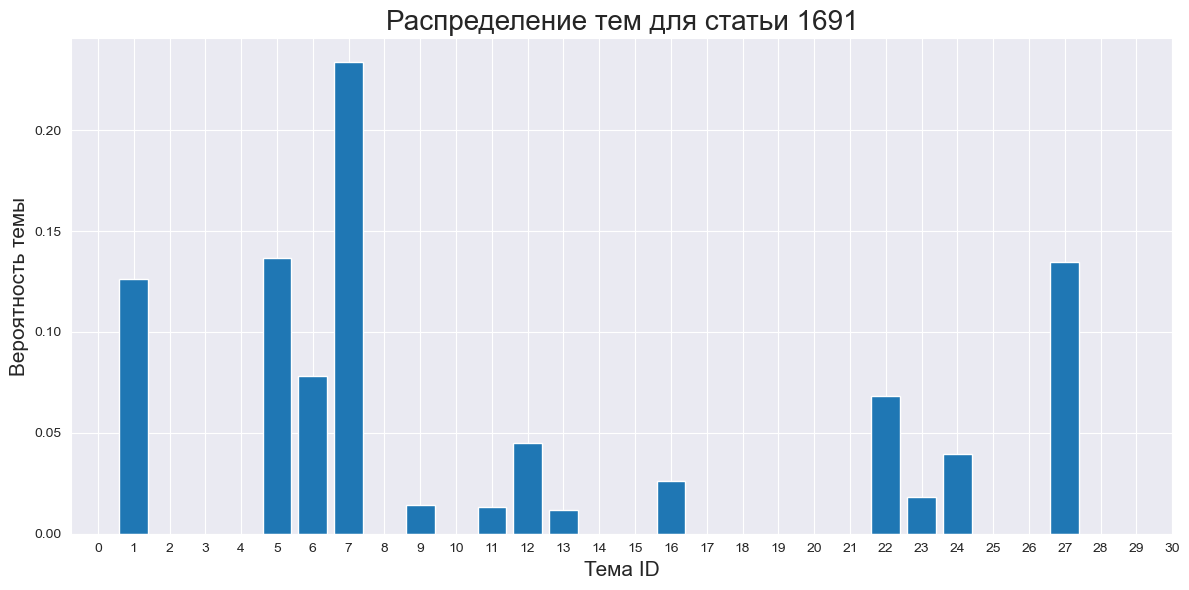

In [45]:
fig, ax = plt.subplots(figsize=(12,6));
patches = ax.bar([i[0] for i in doc_distribution], [i[1] for i in doc_distribution])
ax.set_xlabel('Тема ID', fontsize=15)
ax.set_ylabel('Вероятность темы', fontsize=15)
ax.set_title("Распределение тем для статьи " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(0,30,31))
fig.tight_layout()
plt.show()

In [46]:
# топ-3 самых вероятных тем для статьи 
for i in sorted(doc_distribution, key = lambda x: x[1], reverse=True)[:3]:
    print(i, lda.show_topic(topicid=int(i[0]), topn=10), "\n")

[7.         0.23387155] [('use', 0.06935408), ('data', 0.034974474), ('model', 0.02720563), ('method', 0.024833534), ('studi', 0.02270389), ('predict', 0.02213715), ('analysi', 0.020281175), ('sampl', 0.018614266), ('test', 0.018463554), ('measur', 0.018443966)] 

[5.         0.13664706] [('system', 0.027113898), ('use', 0.023788767), ('structur', 0.021444336), ('develop', 0.019674428), ('gener', 0.017225089), ('demonstr', 0.017142309), ('new', 0.01652579), ('process', 0.015572715), ('provid', 0.01516316), ('potenti', 0.014259954)] 

[27.          0.13454825] [('organ', 0.04065675), ('properti', 0.031236965), ('size', 0.0281833), ('transport', 0.028130636), ('distribut', 0.024881277), ('estim', 0.023251822), ('separ', 0.021150887), ('strain', 0.020487588), ('order', 0.01968509), ('scale', 0.017458849)] 



### Данная статья с вероятностью 0.23 относится к 7 теме - тема посвящена анализу данных, с вероятностью 0.13 относится к 5 теме - разработке, с вероятностью 0.13 относится к 27 теме - свойствам.

In [49]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.244153 -0.000297       1        1  14.519418
5     -0.178729 -0.218933       2        1  12.594960
7     -0.201949  0.053003       3        1   9.003896
11    -0.174875 -0.189213       4        1   7.713160
13    -0.170195 -0.144200       5        1   5.812458
28    -0.145058 -0.005538       6        1   5.755403
8     -0.122329  0.194459       7        1   4.969555
16    -0.159824  0.196988       8        1   4.697677
12    -0.050061 -0.053463       9        1   3.845160
27    -0.004771 -0.006381      10        1   3.471361
18    -0.130729  0.182905      11        1   2.919734
22     0.042361 -0.059884      12        1   2.576360
2     -0.027184  0.199526      13        1   1.981676
6      0.063377 -0.043848      14        1   1.729978
20     0.065846 -0.046025      15        1   1.725996
26     0.119396 -0.023228      16        1   1.641802
19     0.068523  0.035343      17        1   1.376281
24     0.114305 -0.024008      18        1   1.291384
17     0.076300 -0.044476      19        1   1.285209
3      0.088036  0.047233      20        1   1.243774
23     0.109652  0.024821      21        1   1.227323
0      0.077834  0.072280      22        1   1.215695
29     0.050710 -0.104372      23        1   1.213123
9      0.007642 -0.053641      24        1   1.145024
15     0.125500  0.029358      25        1   0.938271
25     0.136225  0.032500      26        1   0.935368
14     0.116591 -0.025213      27        1   0.852422
10     0.131212  0.010990      28        1   0.836641
21     0.079473 -0.024517      29        1   0.814044
4      0.136873 -0.012173      30        1   0.666851, topic_info=            Term         Freq        Total Category  logprob  loglift
114         cell  9257.000000  9257.000000  Default  30.0000  30.0000
452      patient  4313.000000  4313.000000  Default  29.0000  29.0000
516       cancer  2839.000000  2839.000000  Default  28.0000  28.0000
178        activ  4758.000000  4758.000000  Default  27.0000  27.0000
94           use  6724.000000  6724.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
177   accomplish     0.042749     1.240851  Topic30 -11.6395   1.6421
2080      member     6.175442   193.547619  Topic30  -6.6665   1.5654
1417       carri     0.042765   360.399100  Topic30 -11.6391  -4.0289
0          addit     0.042749  1212.708283  Topic30 -11.6395  -5.2427
1      administr     0.042749   362.927684  Topic30 -11.6395  -4.0363

[1322 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1006     28  0.989328         aa
2046     19  0.995986      aberr
844       4  0.399339        abl
844      15  0.594933        abl
1533      5  0.093611     abnorm
...     ...       ...        ...
99       17  0.092062       year
2334     12  0.992609      yeast
543       2  0.115140      yield
543      10  0.880821      yield
2193     28  0.994818  zebrafish

[1906 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 8, 12, 14, 29, 9, 17, 13, 28, 19, 23, 3, 7, 21, 27, 20, 25, 18, 4, 24, 1, 30, 10, 16, 26, 15, 11, 22, 5])

## Визуализация темы и ключевых слов

### Круги на левом графике представляют темы. Чем больше круг, тем больше распространена эта тема.